# **Hand Gesture Recognition – MobileNetV2**


## Import Libraries

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pickle

import tensorflow as tf
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix

import seaborn as sns

from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model

## Load Dataset

In [2]:
# Path of LeapGestRecog dataset
data_path = r"C:\Users\Enter Computer\Desktop\leapGestRecog" 
img_size = 128 # Resize all images to 128×128

X, y, subjects = [], [], [] # Lists to store images, labels, and subject IDs

# Folders representing gesture classes
gesture_folders = [
    '01_palm', '02_l', '03_fist', '04_fist_moved', '05_thumb',
    '06_index', '07_ok', '08_palm_moved', '09_c', '10_down'
]
# Loop over subjects and gestures
for subject in sorted(os.listdir(data_path)):
    subject_path = os.path.join(data_path, subject)
    if not os.path.isdir(subject_path):
        continue

    for gesture in gesture_folders:
        gesture_path = os.path.join(subject_path, gesture)
        if not os.path.isdir(gesture_path):
            continue
        # Load each image
        for img_name in os.listdir(gesture_path):
            img_path = os.path.join(gesture_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (img_size, img_size))
            X.append(img)
            y.append(gesture)
            subjects.append(subject)
            
# Convert lists → arrays
X = np.array(X, dtype="float32")
y = np.array(y)
subjects = np.array(subjects)

print("Total samples:", X.shape[0])


Total samples: 19600


## Encode Labels

In [3]:
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Convert to one-hot representation
y_cat = to_categorical(y_encoded, num_classes=len(np.unique(y)))

##  Split Dataset by Subject (to avoid identity leakage)

In [4]:
train_subjects = ["00","01","02","03","04"]
val_subjects   = ["08","06" ,"05"]
test_subjects  = ["09","07"]

# Print samples per split
print("Subjects in Train:", np.unique(subjects[np.isin(subjects, train_subjects)]))
print("Subjects in Val:", np.unique(subjects[np.isin(subjects, val_subjects)]))
print("Subjects in Test:", np.unique(subjects[np.isin(subjects, test_subjects)]))

# Split images & labels
X_train = X[np.isin(subjects, train_subjects)]
y_train = y_cat[np.isin(subjects, train_subjects)]

X_val = X[np.isin(subjects, val_subjects)]
y_val = y_cat[np.isin(subjects, val_subjects)]

X_test = X[np.isin(subjects, test_subjects)]
y_test = y_cat[np.isin(subjects, test_subjects)]

print(f"Split done:\nTrain: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

Subjects in Train: ['00' '01' '02' '03' '04']
Subjects in Val: ['05' '06' '08']
Subjects in Test: ['07' '09']
Split done:
Train: (9600, 128, 128), Val: (6000, 128, 128), Test: (4000, 128, 128)


## Fix Dimensions (add channel axis)

In [5]:
if X_train.ndim == 3: # Means images are (128,128) instead of (128,128,1)
    X_train = np.expand_dims(X_train, axis=-1)
    X_val = np.expand_dims(X_val, axis=-1)
    X_test = np.expand_dims(X_test, axis=-1)

## Convert Grayscale → RGB (MobileNet requires 3 channels)

In [6]:
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb   = np.repeat(X_val, 3, axis=-1)
X_test_rgb  = np.repeat(X_test, 3, axis=-1)

print("Shapes after RGB conversion:")
print("Train:", X_train_rgb.shape)
print("Val:", X_val_rgb.shape)
print("Test:", X_test_rgb.shape)


Shapes after RGB conversion:
Train: (9600, 128, 128, 3)
Val: (6000, 128, 128, 3)
Test: (4000, 128, 128, 3)


## Data Augmentation

In [7]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    
    rotation_range=45,        
    width_shift_range=0.25,    
    height_shift_range=0.25,   
    shear_range=0.3,           
    zoom_range=[0.7, 1.4],      
  
    brightness_range=[0.3, 1.7],  
    channel_shift_range=40.0,      
    
    horizontal_flip=True,         
    fill_mode='nearest',           
)



test_val_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
train_gen_rgb = train_datagen.flow(X_train_rgb, y_train, batch_size=64, shuffle=True)
val_gen_rgb   = test_val_datagen.flow(X_val_rgb, y_val, batch_size=64, shuffle=False)
test_gen_rgb  = test_val_datagen.flow(X_test_rgb, y_test, batch_size=64, shuffle=False)


## Callbacks

In [8]:
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True
    ),
    ModelCheckpoint(
        filepath='best_cnn(1).h5',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=3,
        min_lr=1e-6,
        verbose=1
    )
]


## Build MobileNetV2 Model

In [9]:
num_classes = len(le.classes_)

# Load MobileNetV2 without its classification head
base = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')

# Freeze first 80 layers to keep pre-trained features
for layer in base.layers[:80]:  
    layer.trainable = False

# Classification head
x = base.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)   
x = Dropout(0.6)(x)
x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001))(x)
x = BatchNormalization()(x)  
x = Dropout(0.6)(x)
out = Dense(num_classes, activation='softmax')(x)


mobilenet_model = Model(inputs=base.input, outputs=out)

mobilenet_model.compile(
    optimizer=Adam(learning_rate=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

mobilenet_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 64, 64, 32)           864       ['input_1[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 64, 64, 32)           128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 64, 64, 32)           0         ['bn_Conv1[0][0]']        

## Train the Model

In [10]:
history_mobilenet = mobilenet_model.fit(
    train_gen_rgb,
    validation_data=val_gen_rgb,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
150/150 [==============================] - ETA: 0s - loss: 3.8776 - accuracy: 0.1335   
Epoch 1: val_loss improved from inf to 2.32298, saving model to best_cnn(1).h5


C:\Users\Enter Computer\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


150/150 [==============================] - 104s 658ms/step - loss: 3.8776 - accuracy: 0.1335 - val_loss: 2.3230 - val_accuracy: 0.2603 - lr: 1.0000e-05
Epoch 2/20
150/150 [==============================] - ETA: 0s - loss: 3.2329 - accuracy: 0.2141  
Epoch 2: val_loss improved from 2.32298 to 1.90784, saving model to best_cnn(1).h5
150/150 [==============================] - 98s 656ms/step - loss: 3.2329 - accuracy: 0.2141 - val_loss: 1.9078 - val_accuracy: 0.3940 - lr: 1.0000e-05
Epoch 3/20
150/150 [==============================] - ETA: 0s - loss: 2.7287 - accuracy: 0.2946  
Epoch 3: val_loss improved from 1.90784 to 1.55186, saving model to best_cnn(1).h5
150/150 [==============================] - 98s 653ms/step - loss: 2.7287 - accuracy: 0.2946 - val_loss: 1.5519 - val_accuracy: 0.5400 - lr: 1.0000e-05
Epoch 4/20
150/150 [==============================] - ETA: 0s - loss: 2.2805 - accuracy: 0.3905  
Epoch 4: val_loss improved from 1.55186 to 1.23137, saving model to best_cnn(1).h5
150

## Evaluation on Test Set

63/63 [==============================] - 17s 263ms/step - loss: 0.3623 - accuracy: 0.9575

Test Accuracy: 95.75%
Test Loss: 0.3623
63/63 [==============================] - 16s 251ms/step

 Classification Report:
               precision    recall  f1-score   support

      01_palm       1.00      1.00      1.00       400
         02_l       1.00      0.96      0.98       400
      03_fist       0.93      0.90      0.91       400
04_fist_moved       0.83      1.00      0.91       400
     05_thumb       1.00      0.94      0.97       400
     06_index       0.87      1.00      0.93       400
        07_ok       1.00      1.00      1.00       400
08_palm_moved       1.00      0.99      0.99       400
         09_c       0.98      0.80      0.88       400
      10_down       1.00      1.00      1.00       400

     accuracy                           0.96      4000
    macro avg       0.96      0.96      0.96      4000
 weighted avg       0.96      0.96      0.96      4000



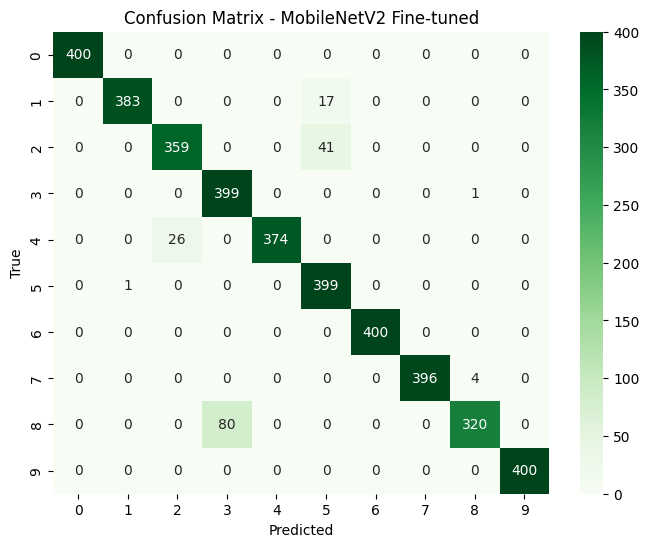

In [11]:
# Evaluate the model on the test set and print accuracy and loss
test_loss, test_acc = mobilenet_model.evaluate(test_gen_rgb, verbose=1)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

# Generate predictions for the test set
y_pred = mobilenet_model.predict(test_gen_rgb)

# Convert prediction probabilities to class labels
y_pred_classes = np.argmax(y_pred, axis=1)

# Convert one-hot encoded true labels to class indices
y_true = np.argmax(y_test, axis=1)

# Print classification report (Precision, Recall, F1-score)
print("\n Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=le.classes_))


# Plot confusion matrix to visualize correct and incorrect classifications
plt.figure(figsize=(8,6))
sns.heatmap(confusion_matrix(y_true, y_pred_classes), annot=True, fmt='d', cmap='Greens')
plt.title("Confusion Matrix - MobileNetV2 Fine-tuned")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



## Plot Training Curves (Accuracy & Loss)

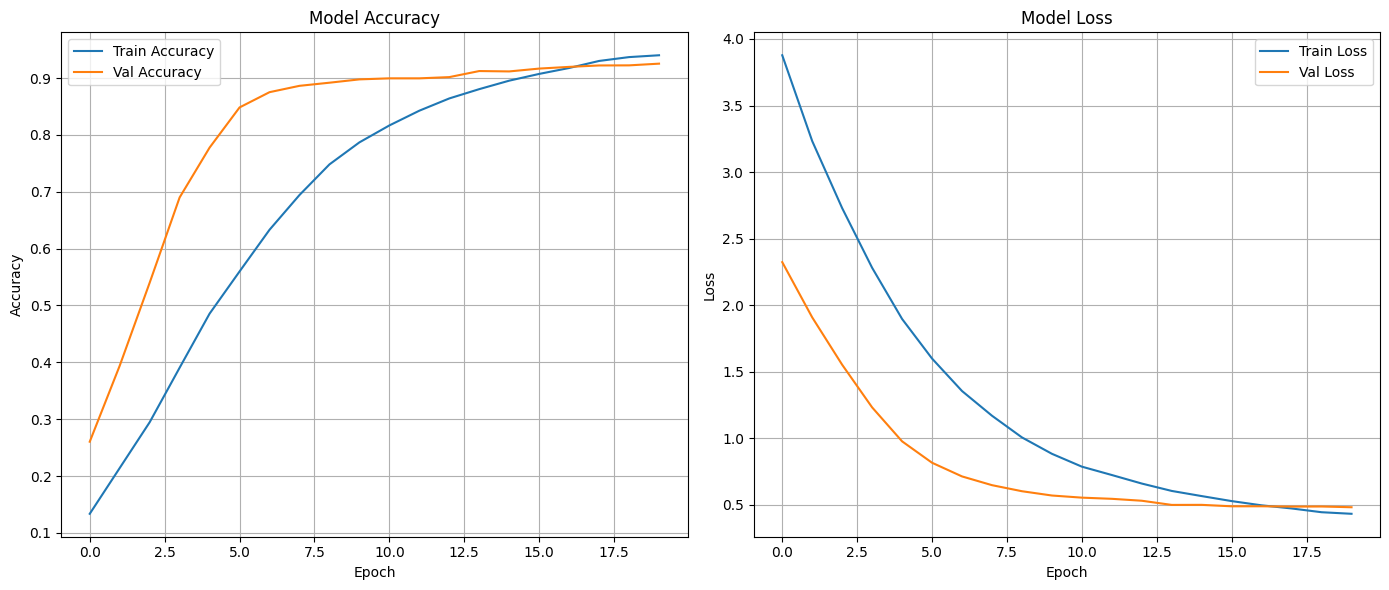

In [12]:
# The fit output is saved as 'history'
hist = history_mobilenet.history

plt.figure(figsize=(14, 6))

# -------- Accuracy Plot --------
plt.subplot(1, 2, 1)
plt.plot(hist['accuracy'], label='Train Accuracy')
plt.plot(hist['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# -------- Loss Plot --------
plt.subplot(1, 2, 2)
plt.plot(hist['loss'], label='Train Loss')
plt.plot(hist['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [13]:
# Open a file in write-binary mode to save the training history
with open('history_mobilenet.pkl', 'wb') as f:
    pickle.dump(history_mobilenet.history, f)

